In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score

plt.style.use('fivethirtyeight')
display(HTML("<style>.container { width:80% !important; }</style>"))

# Read input files

In [2]:
# Decided to use both input dataset 1 and 2 to get more data to train on
#df = pd.read_parquet("../container-data/input_dataset-1.parquet")
df = pd.read_parquet("../container-data/input_dataset-2.parquet")
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")

In [3]:
pred_cols = ["Bolt_"+str(x)+"_Tensile" for x in range(1,7)]+list(pred_df.columns)
pred_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'mode']

In [4]:
#df = pd.concat([df1.loc[:,pred_cols], df2.loc[:,pred_cols]], axis=0)

In [5]:
#df.to_pickle("../container-data/df.pkl")

In [6]:
#df = pd.read_pickle("../container-data/df.pkl")
df = df.loc[:,pred_cols]

In [7]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode'],
      dtype='object')

# Common preprocessing

In [8]:
# Want to extract the time of the earliest datapoint in the dataset
start_time = df.index.min()
start_time

Timestamp('1970-12-19 09:51:44')

In [9]:
df.head()

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,,,,,,,
1970-12-19 09:51:44,1598.481390,1480.989917,1684.247079,1601.359944,1635.585700,1674.848803,262.204308,2.899036,82.279976,173.955216,5310.799181,107.964278,operation
1970-12-19 09:51:45,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,operation
1970-12-19 09:51:46,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,operation
1970-12-19 09:51:47,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,operation
1970-12-19 09:51:48,1598.494073,1481.059017,1684.271062,1601.378391,1635.591746,1674.872300,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,operation


In [10]:
def common_prep(df):
    df["datetime"] = df.index.values
    df.index = np.arange(len(df))
    # We drop rows with missing. No use in trying to impute. Creates more uncertainty.
    df = df.dropna()
    return df

In [11]:
df = common_prep(df)

Want to make a holdout dataset for validation. This is held separate from crossvalidation.

The holdout-set is chosen as 20% of the data. (Not chunked in time.)

Argue that we do not get data leakage from the future, but get better validation that we are able to model dependencies across the whole dataset. 

In [12]:
def split_trn_val(df, frac=0.2):
    df = df.copy()
    val_inds = np.random.choice(df.index.values, size=int(len(df)*frac), replace=False)
    val_df = df.iloc[df.index.isin(val_inds)]
    trn_df = df.iloc[~df.index.isin(val_inds)]
    return trn_df, val_df

In [13]:
trn_df, val_df = split_trn_val(df)

In [14]:
len(trn_df), len(val_df)

(1400000, 350000)

In [15]:
val_df_dt = val_df["datetime"]

In [16]:
#trn_df.to_pickle("../container-data/trn_df.pkl")

In [17]:
#val_df.to_pickle("../container-data/val_df.pkl")

In [18]:
y_cols = ["Bolt_"+str(count)+"_Tensile" for count in range(1,7)]
y_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile']

In [19]:
def add_diff_cols(df):
    return df

In [20]:
def diff_bolt_pretension(df):
    pret = pd.read_csv("../container-data/bolt_pretension.csv", header=None)
    pret_dict = pd.Series(pret.iloc[:,1].values, index=pret.iloc[:,0]).to_dict()
    for y in y_cols:
        df[y] = df[y]-pret_dict[y.strip("_Tensile").replace("_", " ")]
    return df

def binarize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: 1 if x=="start" else 0)
    return df

def categorize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: "start" if x==1 else "operation")
    return df

def add_mode_switch(df):
    df["mode_switch"] = df["mode"]-(df["mode"].shift(fill_value=False))
    return df

def add_sec_since_switch(df):
    df["sec_since_switch"] = (df.groupby('mode')['datetime'].transform(lambda x: (x-x.min()).dt.seconds))
    return df

def add_days_since_start(df):
    df["days_since_start"] = (df["datetime"]-start_time).dt.days
    return df

def add_rolling_sum_speed(df, periods=[60,60*5, 60*60]):
    for period in periods:
        df["Turbine_Rotational Speed_sum"+str(period)] = df["Turbine_Rotational Speed"].rolling(period, min_periods=1).sum()
    return df

def remove_cols(df):
    remove_cols = ["datetime"]
    df = df.drop(remove_cols, axis=1)
    return df

def preprocessing(df):
    # Those that are commented out was left out as no improvement in cv score was shown
    #df = diff_bolt_pretension(df)
    df = binarize_mode(df)
    df = add_mode_switch(df)
    df = add_sec_since_switch(df)
    df = add_days_since_start(df)
    #df = add_rolling_sum_speed(df)
    df = remove_cols(df)
    df = categorize_mode(df)
    return df

def split_x_y(df):
    X = df.drop(y_cols, axis=1)
    y = df.loc[:, y_cols]
    return X, y

In [21]:
trn_df = preprocessing(trn_df)
df_X_train, df_y_train = split_x_y(trn_df)

In [22]:
val_df = preprocessing(val_df)
df_X_val, df_y_val = split_x_y(val_df)

In [23]:
x_cols = set([x for x in df_X_train.columns])-set(y_cols)
x_cols

{'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'days_since_start',
 'mode',
 'mode_switch',
 'sec_since_switch'}

# Make column selectors

In [24]:
X = df_X_train
y = df_y_train

In [25]:
from sklearn.compose import make_column_selector

In [26]:
df.dtypes

Bolt_1_Tensile                           float64
Bolt_2_Tensile                           float64
Bolt_3_Tensile                           float64
Bolt_4_Tensile                           float64
Bolt_5_Tensile                           float64
Bolt_6_Tensile                           float64
Unit_4_Power                             float64
Unit_4_Reactive Power                    float64
Turbine_Guide Vane Opening               float64
Turbine_Pressure Drafttube               float64
Turbine_Pressure Spiral Casing           float64
Turbine_Rotational Speed                 float64
mode                                      object
datetime                          datetime64[ns]
dtype: object

In [27]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X), num_selector(X)

(['mode', 'mode_switch'],
 ['Unit_4_Power',
  'Unit_4_Reactive Power',
  'Turbine_Guide Vane Opening',
  'Turbine_Pressure Drafttube',
  'Turbine_Pressure Spiral Casing',
  'Turbine_Rotational Speed',
  'sec_since_switch',
  'days_since_start'])

# Make column transformers

## Tree preprocessor

In [28]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA250>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA730>)])

## Linear preprocessor

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA250>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA730>)])

# Make pipelines

## Lasso pipeline

In [61]:
from sklearn.linear_model import LassoCV, RidgeCV, MultiTaskLassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True, selection="random", max_iter=1000))
lasso_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA250>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA730>)])),
                ('lassocv',
                 LassoCV(cv=3, n_jobs=4, selection='random', verbose=Tru

## Random forest pipeline

In [62]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA250>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA730>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=3, n_jobs=6,
                                       random_state=42))])

# Stacking regressor  

In [64]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Lasso", lasso_pipeline),
    ("Random Forest", rf_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(cv=KFold(n_splits=3, shuffle=False), scoring="neg_mean_absolute_percentage_error"))
stacking_regressor

StackingRegressor(estimators=[('Lasso',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline',
                                                                                 Pipeline(steps=[('standardscaler',
                                                                                                  StandardScaler()),
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023AACDDA250>),
                                                                                ('onehotencoder',
                                             

# Cross-validation

In [39]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)
fold = 1
scores = {}
preds = {}
residuals = {}
trained_models = {}
for train_index, test_index in kf.split(df_X_train):
    scores[fold] = {}
    preds[fold] = {}
    residuals[fold] = {}
    trained_models[fold] = {}
    print(fold)
    X_train, X_test = df_X_train.iloc[train_index], df_X_train.iloc[test_index]
    for y in y_cols:
        print(y)
        scores[fold][y] = {}
        preds[fold][y] = {}
        residuals[fold][y] = {}
        trained_models[fold][y] = {}
        drop_cols = [x for x in y_cols if x!=y]
        print(drop_cols)
        y_train, y_test = df_y_train.iloc[train_index].drop(drop_cols, axis=1).values.flatten(), df_y_train.iloc[test_index].drop(drop_cols, axis=1)
        for (name, model) in estimators + [("Stacking Regressor", stacking_regressor)]:
            print(name)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = mean_absolute_percentage_error(y_test, y_pred, multioutput="raw_values")
            print(score)
            scores[fold][y][name] = score
            preds[fold][y][name] = y_pred
            residuals[fold][y][name] = y_pred-y_test.values.flatten()
            trained_models[fold][y][name] = model
    fold = fold+1

1
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.5s finished


[0.0004125]
Bolt_2_Tensile
['Bolt_1_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.8s finished


[0.00047392]
Bolt_3_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.9s finished


[0.00035049]
Bolt_4_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
................................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.8006538125919, tolerance: 256.8895396989365
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439.36231541697634, tolerance: 256.8895396989365
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective

[0.0004908]
Bolt_5_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
.............................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.7335307098692, tolerance: 221.92910231064747
  model = cd_fast.enet_coordinate_descent_gram(
.....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 402.8926163915312, tolerance: 221.92910231064747
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converg

.[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.1s finished


[0.00049964]
Bolt_6_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.3s finished


[0.00042319]
2
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.2s finished


[0.00041253]
Bolt_2_Tensile
['Bolt_1_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.6s finished


[0.00047372]
Bolt_3_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.2s finished


[0.0003485]
Bolt_4_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
..................................................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413.83511227939744, tolerance: 262.58676954581614
  model = cd_fast.enet_coordinate_descent_gram(
.....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.6138927329448, tolerance: 262.58676954581614
  model = cd_fast.enet_coordinate_descent_gram(
.....................................................................................................[Para

[0.00048929]
Bolt_5_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
........................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342.362433149945, tolerance: 226.5351252952473
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 626.1115491364617, tolerance: 226.5351252952473
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You mig

.[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.1s finished


[0.00049812]
Bolt_6_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.1s finished


[0.00042304]
3
Bolt_1_Tensile
['Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.5s finished


[0.00041282]
Bolt_2_Tensile
['Bolt_1_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.1s finished


[0.00047573]
Bolt_3_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.4s finished


[0.00034876]
Bolt_4_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_5_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
.....................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 457.5705196723575, tolerance: 257.60742354633595
  model = cd_fast.enet_coordinate_descent_gram(
.....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371.363091428997, tolerance: 257.60742354633595
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not 

[0.00049343]
Bolt_5_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_6_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
...........................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.0934496126138, tolerance: 222.34311220649715
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.3656332939863, tolerance: 222.34311220649715
  model = cd_fast.enet_coordinate_descent_gram(
...C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to

.[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    7.0s finished


[0.00049919]
Bolt_6_Tensile
['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile', 'Bolt_5_Tensile']
Lasso


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    6.5s finished


[0.00042336]


In [44]:
residuals

{}

# Make predictions on validation set

In [66]:
scores = {}
preds = {}
residuals = {}
models = {}
for y in y_cols:
    print(y)
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y_train.drop(drop_cols, axis=1).values.flatten()
    y_val = df_y_val.drop(drop_cols, axis=1).values.flatten()
    model = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True, selection="random", max_iter=1000))
    model.fit(df_X_train, y_train)
    y_pred = model.predict(df_X_val)
    score = mean_absolute_percentage_error(y_val, y_pred)
    print(score)
    scores[y] = score
    preds[y] = y_pred
    residuals[y] = y_pred-y_val
    models[y] = model

Bolt_1_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    2.7s finished


0.00041282482026638347
Bolt_2_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.0s finished


0.00047484663680656393
Bolt_3_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.1s finished


0.00034874322740003814
Bolt_4_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
...............................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.7407604977489, tolerance: 388.5453574330949
  model = cd_fast.enet_coordinate_descent_gram(
.....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 613.8171333634527, tolerance: 388.5453574330949
  model = cd_fast.enet_coordinate_descent_gram(
....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not conver

0.0004897895071860078
Bolt_5_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
...................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 932.6413904826622, tolerance: 335.4027707903404
  model = cd_fast.enet_coordinate_descent_gram(
....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 998.1223899153993, tolerance: 335.4027707903404
  model = cd_fast.enet_coordinate_descent_gram(
............................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sk

.[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.3s finished


0.0004987700719237374
Bolt_6_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.1s finished


0.0004229523468079215


# Investigate results

In [60]:
for y in y_cols:
    a = models[y].steps[-1][1].alpha_
    coefs = models[y].steps[-1][1].coef_
    intercept = models[y].steps[-1][1].intercept_
    print(a)
    print(coefs)
    print(intercept)

0.010272815990999816
[ 3.26762363  0.         -0.          1.91244025  0.          1.39420872
  0.27901333 10.3355319  -0.          0.          0.          0.
 -0.        ]
1613.2769967566187
0.12204020470665401
[ 0.20888342  0.          1.02215064 -0.          0.          1.10303492
  0.          6.11191387  0.         -0.         -0.          0.
 -0.        ]
1490.36379467712
0.0902935851773336
[ 0.55474899  0.05907177  0.27942024 -0.         -0.          0.22865265
  0.          4.5125649   0.         -0.         -0.          0.
 -0.        ]
1690.2547346761987
0.32581852179587084
[ 0.          0.          1.18017032 -0.         -0.          0.56685684
  0.          0.61764544  0.         -0.         -0.          0.
 -0.        ]
1602.8958871682505
0.33897923653829337
[ 0.          0.          0.9117303  -0.         -0.          0.49288967
 -0.          0.38450756  0.         -0.         -0.          0.
 -0.        ]
1637.4207518798084
0.0037204692625481465
[ 3.64511094  0.10611503 

In [47]:
scores

{'Bolt_1_Tensile': 0.00041289120697323854,
 'Bolt_2_Tensile': 0.0004747933360997181,
 'Bolt_3_Tensile': 0.0003483201275933176,
 'Bolt_4_Tensile': 0.0004897819519889367,
 'Bolt_5_Tensile': 0.000498770245764835,
 'Bolt_6_Tensile': 0.00042295235419006935}

In [ ]:
score_df = pd.DataFrame.from_dict(scores, orient="index")
score_df.plot(kind="bar", figsize=(24,18))

In [ ]:
score_df.mean()

# Plot feature importances

In [ ]:
models

In [ ]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(30,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        model = models[name]
        imps = pd.Series(model.feature_importances_, index=df_X_val.columns)
        imps.plot(kind="bar", ax=axes[r,c], title=name)
        count+=1

It is interesting to see that days_since_start matters more for the bolts that are more difficult to predict.

# Plot residuals

Where do we miss?

In [67]:
res_df = pd.DataFrame(data=np.transpose([residuals[y] for y in y_cols]), index=val_df_dt, columns=y_cols)

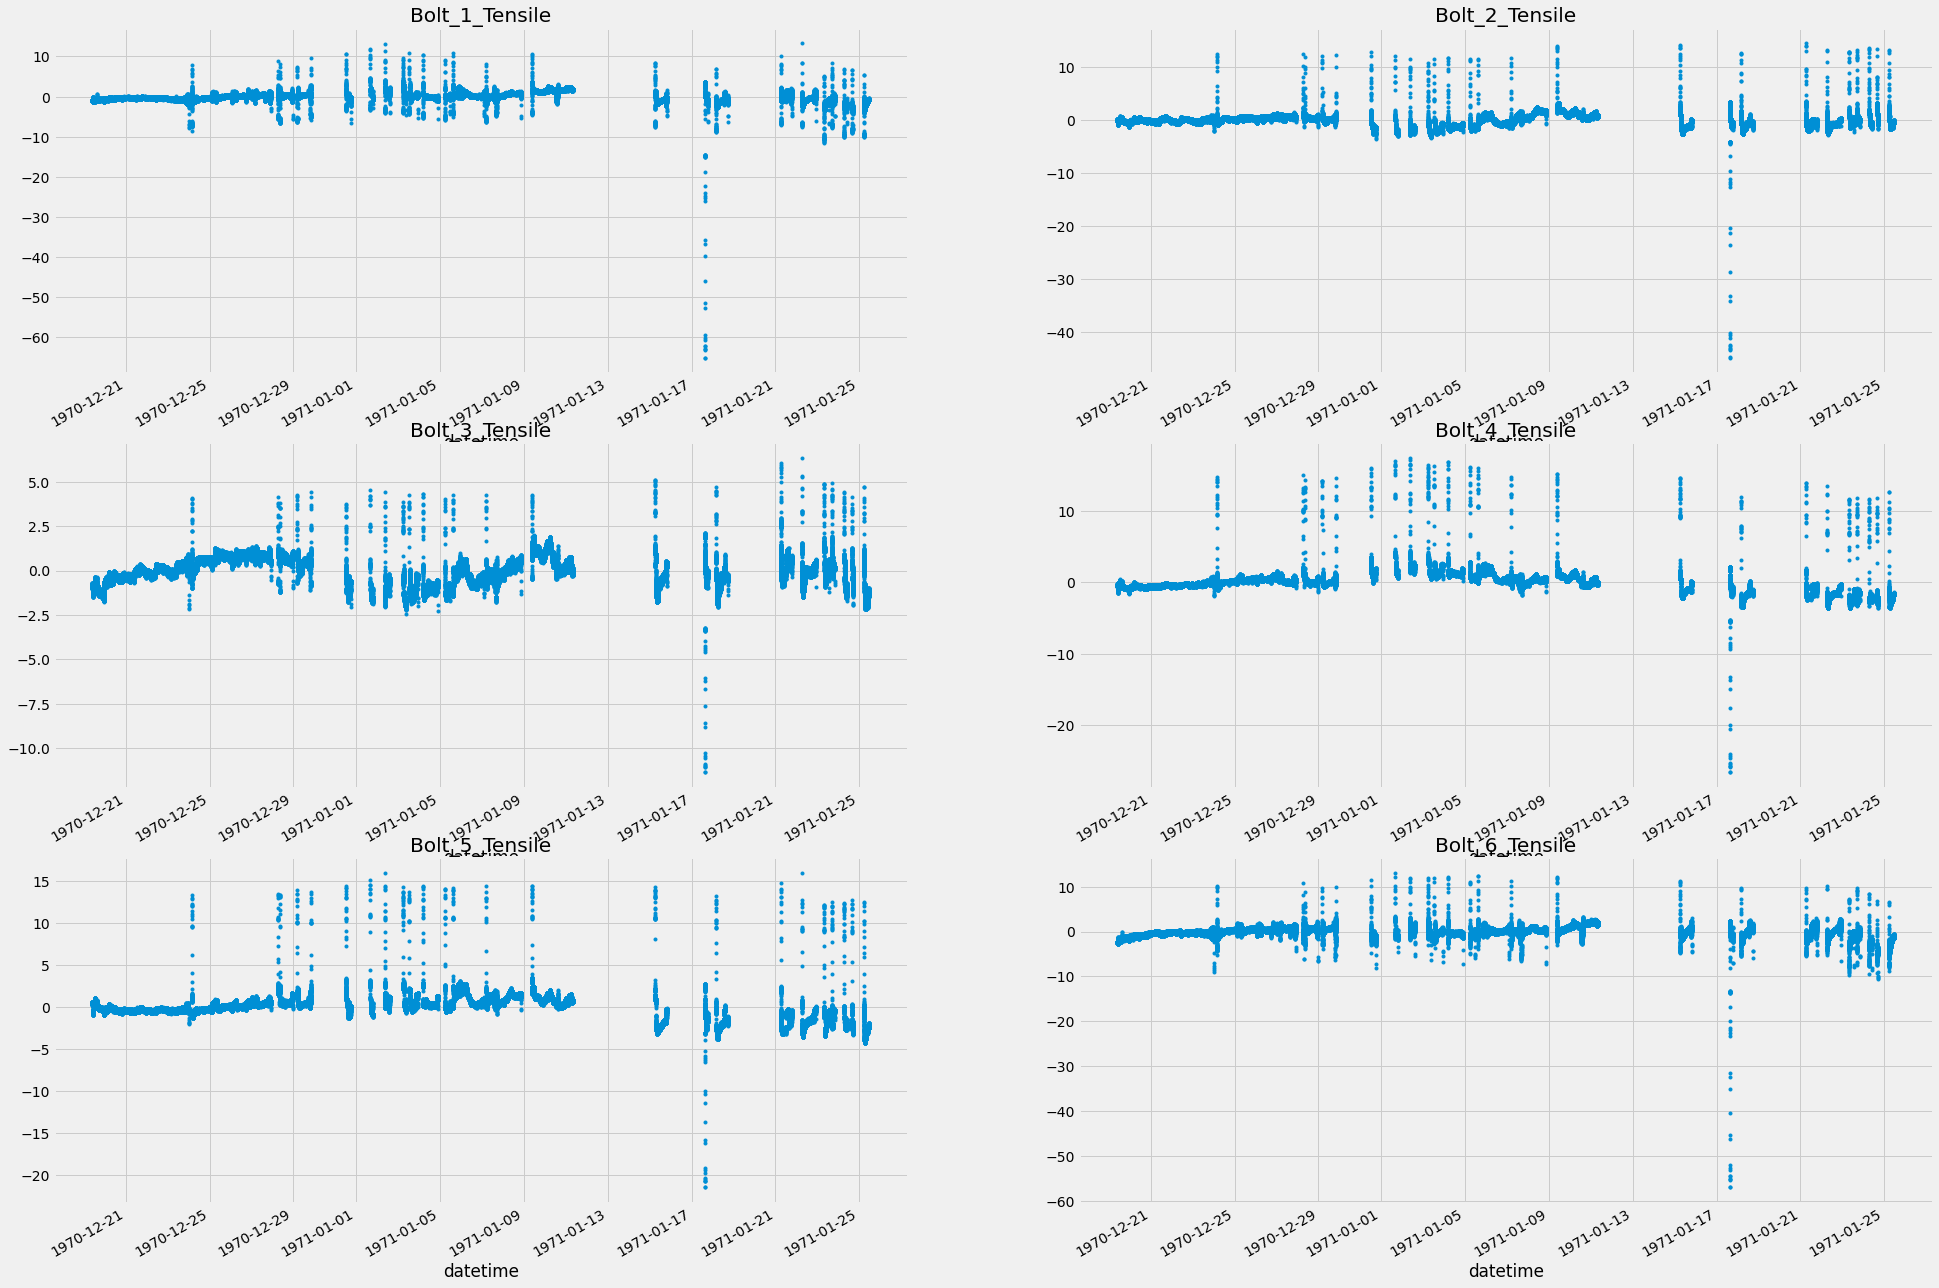

In [68]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(30,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        res_df[name].plot(style=".", ax=axes[r,c], title=name)
        count+=1

# Train final model with whole dataset

In [69]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode', 'datetime'],
      dtype='object')

In [70]:
final_df = preprocessing(df)

In [71]:
df_X, df_y = split_x_y(final_df) 

In [72]:
df_X.columns, df_y.columns

(Index(['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
        'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
        'Turbine_Rotational Speed', 'mode', 'mode_switch', 'sec_since_switch',
        'days_since_start'],
       dtype='object'),
 Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
        'Bolt_5_Tensile', 'Bolt_6_Tensile'],
       dtype='object'))

In [ ]:
fitted = {}
out_preds = {}
for y in y_cols:
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y.drop(drop_cols, axis=1).values.flatten()
    model = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True, selection="random", max_iter=1000))
    model.fit(df_X, y_train)
    fitted[y] = model
    out_preds[y] = model.predict(df_X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
....................

.[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    4.1s finished


In [ ]:
out_preds

# Apply same preprocessing to input prediction data

In [77]:
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")
pred_df = common_prep(pred_df)
pred_df_prep = preprocessing(pred_df)

In [84]:
pred_df.loc[:,df_X.columns].isnull()

Unit_4_Power                      0
Unit_4_Reactive Power             0
Turbine_Guide Vane Opening        0
Turbine_Pressure Drafttube        0
Turbine_Pressure Spiral Casing    0
Turbine_Rotational Speed          0
mode                              0
mode_switch                       0
sec_since_switch                  0
days_since_start                  0
dtype: int64

## Make predictions with final model for submission

In [86]:
for y_col, pipeline in fitted.items():
    pred_df[y_col] = pipeline.predict(pred_df.loc[:,df_X.columns])

C:\Users\tthoresen\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\tthoresen\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [78]:
preds = model.predict(pred_df.loc[:,df_X.columns])

C:\Users\tthoresen\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:579: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\tthoresen\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
df_preds = pd.DataFrame(preds, columns=df_y.columns)
df_preds

In [ ]:
out_df = pd.concat([df_preds, pred_df["datetime"]], axis=1).set_index("datetime")
out_df

In [ ]:
assert (orig.index == out_df.index).all()

In [ ]:
pred_df.to_csv("../container-data/prediction_output_lasso.csv")